In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
%matplotlib inline
import torch.optim as optim
import torchvision.utils as vutils
import torch.backends.cudnn as cudnn
print(torch.__version__)
from torchsummary import summary
from torchvision.utils import save_image
from sklearn.preprocessing import MinMaxScaler

1.8.1+cu101


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# parameters
CUDA = True
ZDIMS = 30
LR = 0.00001
BATCH_SIZE = 64
SEED = 4
LOG_INTERVAL = 10

In [4]:
# change path as required
path = '/content/drive/MyDrive/ecg/'

In [5]:
# Load these files that are generated by the Sampling MLII Beats Only for Generative Models Notebook
train_mlii = np.loadtxt(path+ "train_test_sampled_mlii/train_mlii.csv", delimiter=',')
test_mlii = np.loadtxt(path+"train_test_sampled_mlii/test_mlii.csv", delimiter=',')

print(train_mlii.shape)
print(test_mlii.shape)

(28936, 259)
(27207, 259)


In [6]:
X_train_old = train_mlii[:,:-3]
y_train_old = train_mlii[:,-3]
X_test_old = test_mlii[:,:-3]
y_test_old = test_mlii[:,-3]

In [7]:
scaler = MinMaxScaler()
X_train_old = scaler.fit_transform(X_train_old)


In [8]:
scaler1 = MinMaxScaler()
X_test_old = scaler1.fit_transform(X_test_old)

In [9]:
# Set num to the class number you want to train the VAE on
# Options: 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, None
# None option trains on all classes together
num = None

In [10]:
if num is not None:
  y_train = y_train_old[np.where(y_train_old == num)[0]]
  X_train = X_train_old[np.where(y_train_old == num)[0]]
  X_test = X_test_old[np.where(y_test_old == num)[0]]
  y_test = y_test_old[np.where(y_test_old == num)[0]]
else:
  y_train = y_train_old
  X_train = X_train_old
  X_test = X_test_old
  y_test = y_test_old

In [11]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(28936, 256)
(28936,)
(27207, 256)
(27207,)


In [12]:
X_train = np.expand_dims(X_train,axis=2)
print(X_train.shape)
X_test = np.expand_dims(X_test, axis=2)
print(X_test.shape)

(28936, 256, 1)
(27207, 256, 1)


In [13]:
tensor_Xtrain = torch.from_numpy(X_train)
tensor_ytrain = torch.from_numpy(y_train)

train_data = Data.TensorDataset(tensor_Xtrain, tensor_ytrain)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [14]:
tensor_Xtest = torch.from_numpy(X_test)
tensor_ytest = torch.from_numpy(y_test)

test_data = Data.TensorDataset(tensor_Xtest, tensor_ytest)
test_loader = Data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [15]:
print(len(train_loader.dataset))

28936


In [16]:
torch.manual_seed(SEED)
device = torch.device('cuda' if CUDA else 'cpu')
kwargs = {'num_workers': 1, 'pin_memory': True} if CUDA else {}
device

device(type='cuda')

In [17]:
# NC = 1    # channels
# NEF = 30  # init encoding filters
# NDF = 30  # init decoding filters

class VAE(nn.Module):
    
    def __init__(self, zdims, beta=0.1, beta_delta=0):
        super(VAE, self).__init__()
        
        self.zdims = zdims
        self.beta = beta
        self.beta_delta = beta_delta

        self.encoder = nn.Sequential(
            
            # input is 64 x 1 x 256
            nn.Conv1d(in_channels = 1, out_channels = 1, kernel_size = 3, stride=2, padding=1),
            nn.BatchNorm1d(1),
            nn.LeakyReLU(0.2),

            # conv layer 2
            nn.Conv1d(in_channels = 1, out_channels = 1, kernel_size = 3, stride=2, padding=1),
            nn.BatchNorm1d(1),
            nn.LeakyReLU(0.2),

            # conv layer 3
            nn.Conv1d(in_channels = 1, out_channels = 1, kernel_size = 3, stride=2, padding=1),
            nn.BatchNorm1d(1),
            nn.LeakyReLU(0.2),

            # conv layer 4 
            nn.Conv1d(in_channels = 1, out_channels = 1, kernel_size = 3, stride=2, padding=1),
            nn.LeakyReLU(0.2)

        )

        self.decoder = nn.Sequential(

            # input is Z (post-fc)
            nn.ConvTranspose1d(in_channels = 1, out_channels = 1, kernel_size = 4, stride=2, padding=1),
            nn.BatchNorm1d(1),
            nn.LeakyReLU(0.2),

            # # deconv layer 2
            nn.ConvTranspose1d(in_channels = 1, out_channels = 1, kernel_size = 4, stride=2, padding=1),
            nn.BatchNorm1d(1),
            nn.LeakyReLU(0.2),

            # deconv layer 3
            nn.ConvTranspose1d(in_channels = 1, out_channels = 1, kernel_size = 4, stride=2, padding=1),
            nn.BatchNorm1d(1),
            nn.LeakyReLU(0.2),

            # deconv layer 4
            nn.ConvTranspose1d(in_channels = 1, out_channels = 1, kernel_size = 4, stride=2, padding=1),
            nn.Sigmoid()


        )
        
        # conv fc
        self.fc11 = nn.Linear(16, self.zdims) # mu
        self.fc12 = nn.Linear(16, self.zdims) # logvar
        
        # deconv fc
        self.fc2  = nn.Linear(self.zdims, 16)

    def encode(self, x):
        conv = self.encoder(x)
        conv = conv.view(BATCH_SIZE,-1)

        mu = self.fc11(conv)
        logvar = self.fc12(conv)

        return mu, logvar
    
    def decode(self, z):
        deconv_input = F.relu(self.fc2(z))

        deconv_input = torch.unsqueeze(deconv_input,1)
        recon_x = self.decoder(deconv_input)

        return recon_x
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(logvar * 0.5)
        eps = torch.rand_like(std)
        z = eps.mul(std).add(mu)
        return z
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar, z
  
    def update_beta(self):
      self.beta += self.beta_delta

In [18]:
model = VAE(zdims = ZDIMS).to(device)
optimizer = optim.Adam(model.parameters(), lr = LR)

In [19]:
print(model)

VAE(
  (encoder): Sequential(
    (0): Conv1d(1, 1, kernel_size=(3,), stride=(2,), padding=(1,))
    (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv1d(1, 1, kernel_size=(3,), stride=(2,), padding=(1,))
    (4): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv1d(1, 1, kernel_size=(3,), stride=(2,), padding=(1,))
    (7): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Conv1d(1, 1, kernel_size=(3,), stride=(2,), padding=(1,))
    (10): LeakyReLU(negative_slope=0.2)
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(1, 1, kernel_size=(4,), stride=(2,), padding=(1,))
    (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose1d(1, 1, kernel_size=(4,), 

In [20]:
def loss_function(recon_x, x, mu, logvar):

    BCE = F.binary_cross_entropy(recon_x, x, reduction = 'mean')

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, KLD, BCE

In [21]:
def train(epoch):


    model.train()
    train_loss = 0
    kld_loss = 0
    bce_loss = 0
    z_list=[]
    for batch_idx, (data, _) in enumerate(train_loader):

        data = data.to(device)

        optimizer.zero_grad()

        data = data.permute(0,2,1)
        recon_batch, mu, logvar, Z = model(data.type(torch.cuda.FloatTensor))
        z_list.append(Z)

        loss, kld, bce = loss_function(recon_batch, data.type(torch.cuda.FloatTensor), mu, logvar)
        loss.backward()
        train_loss += loss.item()
        kld_loss += kld.item()
        bce_loss += bce.item()
        optimizer.step()
        
        model.update_beta()

        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch,
                batch_idx * len(data),
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)
            ))
    data_inv = scaler.inverse_transform(data.view(-1,256).detach().cpu().numpy())
    recon_batch_inv = scaler.inverse_transform(recon_batch.view(-1,256).detach().cpu().numpy())
    
    if(epoch==99):

      f, a = plt.subplots(2, 5, figsize=(20,5))
      view_data = data_inv[:5]
      view_recon = recon_batch_inv[:5]

      for i in range(5):
          a[0][i].plot(view_data[i])

      for i in range(5):
          a[1][i].clear()
          a[1][i].plot(view_recon[i])
      plt.show();
    print('====> Epoch: {} Average loss: {:.4f} KLD {:.4f} BCE {:.4f}'.format(
        epoch,
        train_loss / len(train_loader.dataset),
        kld_loss / len(train_loader.dataset),
        bce_loss / len(train_loader.dataset)
    ))
    return train_loss / len(train_loader.dataset), kld_loss / len(train_loader.dataset), bce_loss / len(train_loader.dataset), z_list

In [22]:
train_loss_list = []
kld_list = []
bce_list = []
for epoch in range(50):
    loss, kld, bce, z_list = train(epoch)
    train_loss_list.append(loss)
    kld_list.append(kld)
    bce_list.append(bce)

Train Epoch: 0 [0/28936 (0%)]	Loss: 4.294314
Train Epoch: 0 [640/28936 (2%)]	Loss: 4.041025
Train Epoch: 0 [1280/28936 (4%)]	Loss: 4.002110
Train Epoch: 0 [1920/28936 (7%)]	Loss: 3.963450
Train Epoch: 0 [2560/28936 (9%)]	Loss: 3.928207
Train Epoch: 0 [3200/28936 (11%)]	Loss: 3.817844
Train Epoch: 0 [3840/28936 (13%)]	Loss: 4.054551
Train Epoch: 0 [4480/28936 (15%)]	Loss: 3.928096
Train Epoch: 0 [5120/28936 (18%)]	Loss: 3.873064
Train Epoch: 0 [5760/28936 (20%)]	Loss: 3.699982
Train Epoch: 0 [6400/28936 (22%)]	Loss: 3.973050
Train Epoch: 0 [7040/28936 (24%)]	Loss: 3.900842
Train Epoch: 0 [7680/28936 (27%)]	Loss: 3.795609
Train Epoch: 0 [8320/28936 (29%)]	Loss: 3.945806
Train Epoch: 0 [8960/28936 (31%)]	Loss: 3.690861
Train Epoch: 0 [9600/28936 (33%)]	Loss: 3.908148
Train Epoch: 0 [10240/28936 (35%)]	Loss: 3.726926
Train Epoch: 0 [10880/28936 (38%)]	Loss: 3.789313
Train Epoch: 0 [11520/28936 (40%)]	Loss: 3.839417
Train Epoch: 0 [12160/28936 (42%)]	Loss: 3.705293
Train Epoch: 0 [12800/289

In [23]:
def plot_image(img, ax, title):
    view_data = img
    time_value = np.arange(256, dtype = 'float')
    ax.grid(zorder=0)
    ax.plot(time_value, view_data)
    ax.set_title(title, fontsize=20)


def plot_encoding(image, model, latent_sz, alpha=1, width=1/7):
    image = image[0]
    image.to(device)
    image = image.permute(0,2,1)
    image_print = scaler.inverse_transform(image.view(-1,256))
    decoded, mu, logvar, z = model.forward(image.type(torch.cuda.FloatTensor))
    z = model.reparameterize(mu, logvar)
    img = scaler.inverse_transform(model.decode(z).view(-1,256).detach().cpu().numpy())
    z = z.cpu().detach().numpy()[0]

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
    
    plot_image(image_print[0,:], ax0, 'Input ECG Beat')
    
    ax1.bar(np.arange(latent_sz), height=z, width=1/7, align='center', color='blue')
    ax1.grid(zorder=0)
    ax1.scatter(np.arange(latent_sz), z, color='blue')
    ax1.set_title(r"Latent Dimension: %d" % latent_sz, fontsize=20)
    
    plot_image(img[0,:], ax2, 'Decoded ECG Beat')
    plt.subplots_adjust(hspace=0.5)

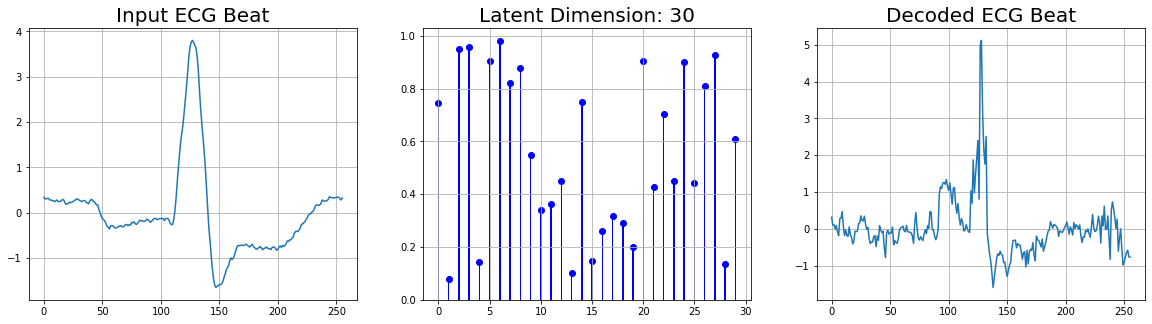

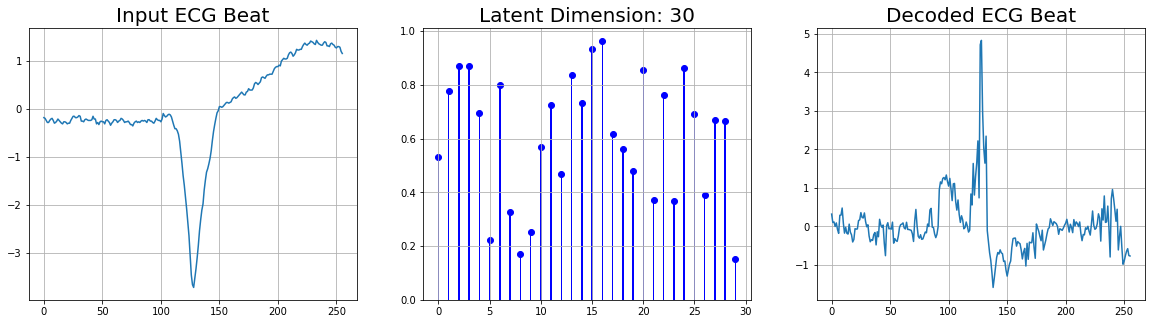

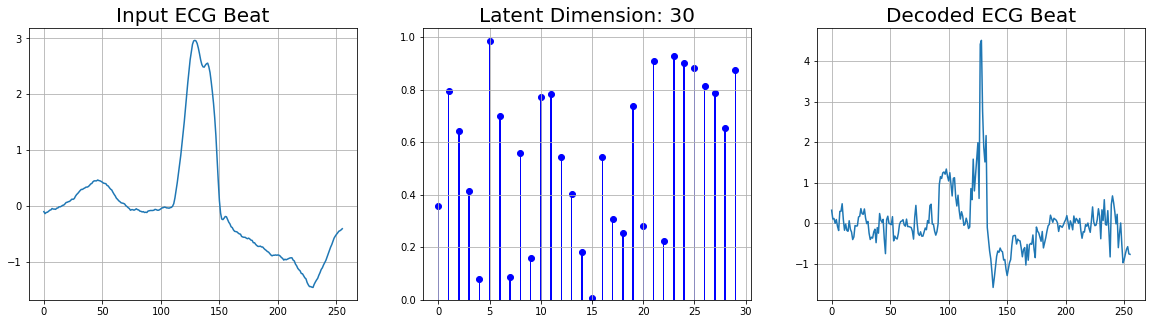

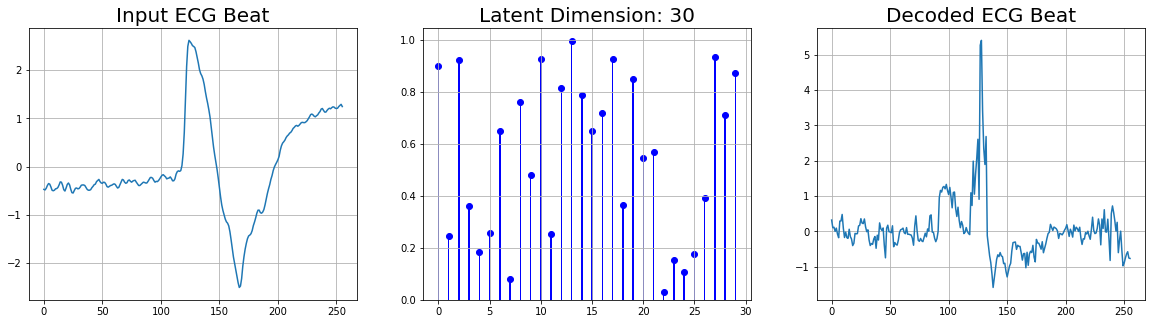

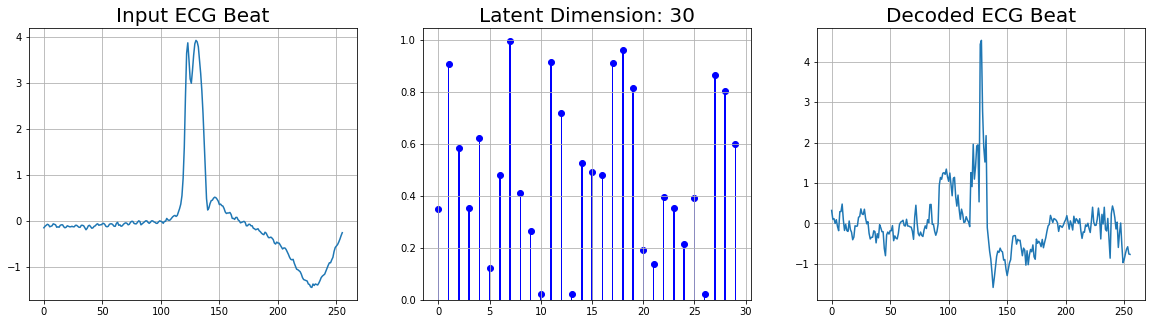

In [24]:
dataloader_iterator = iter(train_loader)
for i in range(10,15):
    try:
        img = next(dataloader_iterator)
    except StopIteration:
        dataloader_iterator = iter(train_loader)
        img = next(dataloader_iterator)
    plot_encoding(img, model, ZDIMS)

In [25]:

from sklearn.manifold import TSNE 
latent_ecg = []
target = []
for data, targets in train_loader:
    z_means, z_logvar = model.encode(data.permute(0,2,1).type(torch.cuda.FloatTensor))
    latent_ecg.extend(z_means.detach().cpu().numpy())
    target.extend(targets.numpy())


latent = np.array(latent_ecg)
target = np.array(target)
tsne = TSNE(n_components=2, random_state=0, verbose=5, n_iter=500)

X = tsne.fit_transform(latent_ecg)




[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 28928 samples in 0.099s...
[t-SNE] Computed neighbors for 28928 samples in 24.156s...
[t-SNE] Computed conditional probabilities for sample 1000 / 28928
[t-SNE] Computed conditional probabilities for sample 2000 / 28928
[t-SNE] Computed conditional probabilities for sample 3000 / 28928
[t-SNE] Computed conditional probabilities for sample 4000 / 28928
[t-SNE] Computed conditional probabilities for sample 5000 / 28928
[t-SNE] Computed conditional probabilities for sample 6000 / 28928
[t-SNE] Computed conditional probabilities for sample 7000 / 28928
[t-SNE] Computed conditional probabilities for sample 8000 / 28928
[t-SNE] Computed conditional probabilities for sample 9000 / 28928
[t-SNE] Computed conditional probabilities for sample 10000 / 28928
[t-SNE] Computed conditional probabilities for sample 11000 / 28928
[t-SNE] Computed conditional probabilities for sample 12000 / 28928
[t-SNE] Computed conditional probabilities for sa

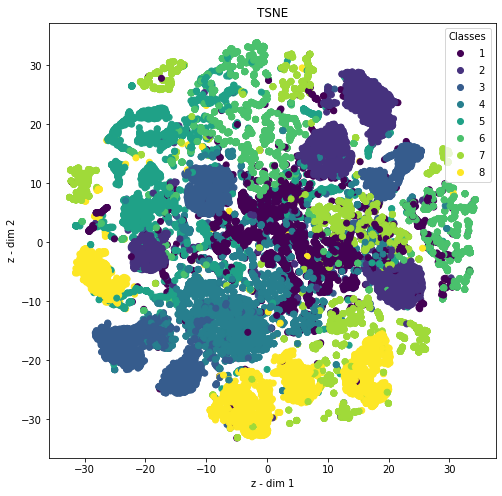

In [26]:
plt.figure(figsize=(8,8))
scatter = plt.scatter(X[:,0], X[:,1], c=target, cmap='viridis')
plt.legend(title="Classes",loc='upper right',*scatter.legend_elements())
plt.xlabel('z - dim 1')
plt.ylabel('z - dim 2')
plt.title('TSNE')
plt.show()

In [27]:
def test(epoch):
    
    model.eval()
    test_loss = 0
    kld_loss =0
    bce_loss =0
    recon_list = []
    z_list = []
    with torch.no_grad():
        
        for i, (data, _) in enumerate(test_loader):

            data = data.to(device)
            data = data.permute(0,2,1)
            recon_batch, mu, logvar, Z = model(data.type(torch.cuda.FloatTensor))
            recon_list.append(recon_batch)
            z_list.append(Z)
            loss, kld, bce = loss_function(recon_batch, data.type(torch.cuda.FloatTensor), mu, logvar)
            test_loss += loss.item()
            kld_loss += kld.item()
            bce_loss += bce.item()

    data_inv = scaler1.inverse_transform(data.view(-1,256).cpu().data.numpy())
    recon_batch_inv = scaler1.inverse_transform(recon_batch.view(-1,256).cpu().data.numpy())
    if(epoch==99):
      f, a = plt.subplots(2, 5, figsize=(20,5))
      view_data = data_inv[:5]
      view_recon = recon_batch_inv[:5]

      for i in range(5):
          a[0][i].plot(view_data[i])

      for i in range(5):
          a[1][i].clear()
          a[1][i].plot(view_recon[i])
      plt.show();
    test_loss /= len(test_loader.dataset)
    kld_loss /= len(test_loader.dataset)
    bce_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss, kld_loss, bce_loss, recon_list, z_list

In [28]:
test_loss_list = []
kld_list_tst = []
bce_list_tst = []
for epoch in range(50):
    loss, kld_loss, bce_loss, recon_list, z_list_test = test(epoch)
    test_loss_list.append(loss)
    kld_list_tst.append(kld_loss)
    bce_list_tst.append(bce_loss)

====> Test set loss: 0.0411
====> Test set loss: 0.0411
====> Test set loss: 0.0411
====> Test set loss: 0.0411
====> Test set loss: 0.0411
====> Test set loss: 0.0411
====> Test set loss: 0.0411
====> Test set loss: 0.0411
====> Test set loss: 0.0411
====> Test set loss: 0.0411
====> Test set loss: 0.0411
====> Test set loss: 0.0411
====> Test set loss: 0.0411
====> Test set loss: 0.0411
====> Test set loss: 0.0411
====> Test set loss: 0.0411
====> Test set loss: 0.0411
====> Test set loss: 0.0411
====> Test set loss: 0.0411
====> Test set loss: 0.0411
====> Test set loss: 0.0411
====> Test set loss: 0.0411
====> Test set loss: 0.0411
====> Test set loss: 0.0411
====> Test set loss: 0.0411
====> Test set loss: 0.0411
====> Test set loss: 0.0411
====> Test set loss: 0.0411
====> Test set loss: 0.0411
====> Test set loss: 0.0411
====> Test set loss: 0.0411
====> Test set loss: 0.0411
====> Test set loss: 0.0411
====> Test set loss: 0.0411
====> Test set loss: 0.0411
====> Test set loss:

## Sample from Latent Space

In [29]:
# sample from latent space

def sample_latent(model, no_samples):
  samples = []
  with torch.no_grad():
    for i in range(no_samples // 64):
      sample = torch.randn(64, ZDIMS).to(device)
      # print(sample.shape)
      sample_decode = model.decode(sample).cpu()
      sample_inv = scaler.inverse_transform(sample_decode.view(-1,256).cpu().data.numpy())
      # sample = sample.permute(0,2,1)
      # print(sample.shape)
      samples.append(sample_inv)
    return samples

In [30]:
samples = sample_latent(model,6000)
print(len(samples))

93


In [31]:
print(samples[0].shape)
all_samps = np.concatenate(samples, axis=0)
print(all_samps.shape)

(64, 256)
(5952, 256)


### Saving synthetic data - Change Path As Required

In [32]:
import os
sv_samps = '/content/drive/MyDrive/ecg/synthetic_data/conv_vae/beat_type' + str(num) + '.csv'
if not os.path.exists('/content/drive/MyDrive/ecg/synthetic_data/conv_vae'):
  os.makedirs('/content/drive/MyDrive/ecg/synthetic_data/conv_vae')
np.savetxt(sv_samps, all_samps, delimiter=',', fmt='%f')

In [33]:
def view_samples(sample):
  f, a = plt.subplots(1, 5, figsize=(40,5))
  view_data = sample[30:35]

  for i in range(5):
      a[i].plot(view_data[i])

      # for i in range(5):
      #     a[1][i].clear()
      #     a[1][i].plot(view_recon.cpu().data.numpy()[i])
  plt.show();

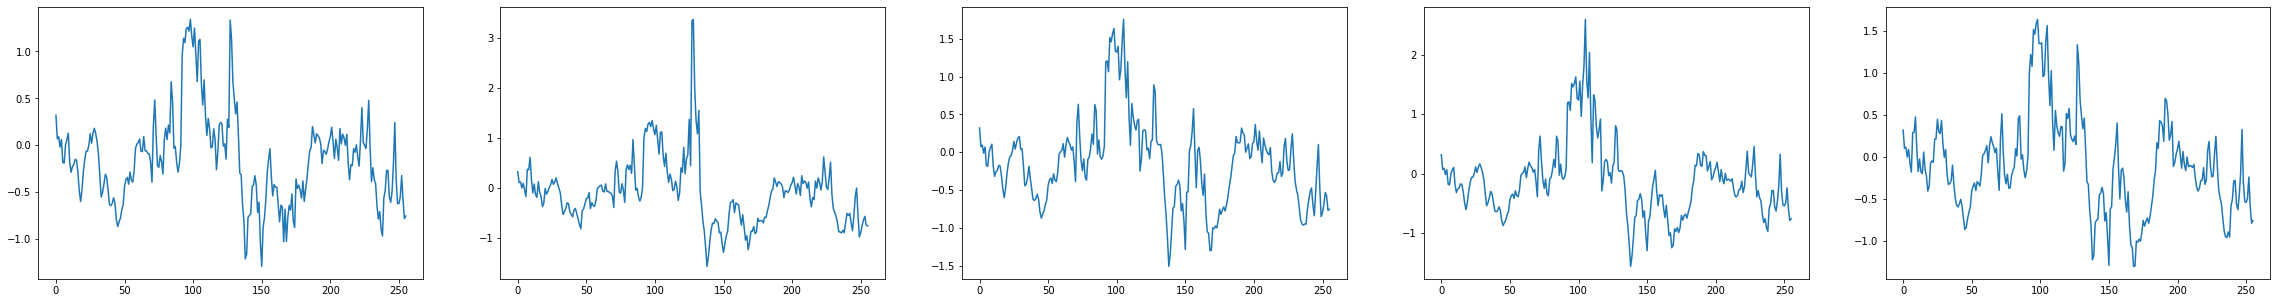

In [34]:
view_samples(all_samps)

## Loss Graphs

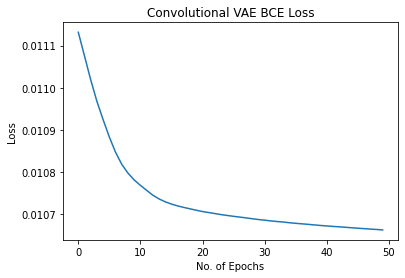

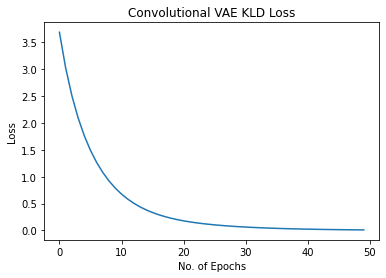

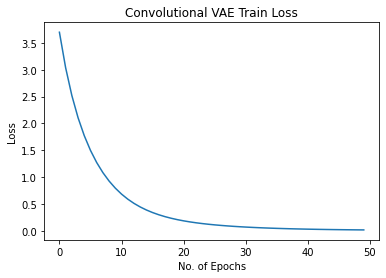

In [35]:
# loss graphs
# print(train_loss_list)
plt.plot(range(len(bce_list)), bce_list)
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")
plt.title("Convolutional VAE BCE Loss")
plt.show()
plt.plot(range(len(kld_list)), kld_list)
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")
plt.title("Convolutional VAE KLD Loss")
plt.show()
plt.plot(range(len(train_loss_list)), train_loss_list)
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")
plt.title("Convolutional VAE Train Loss")
plt.show()

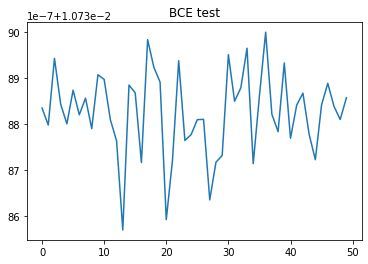

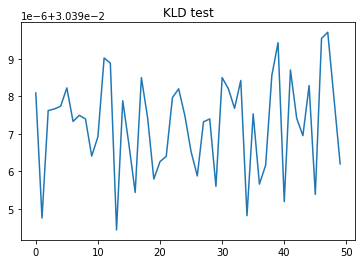

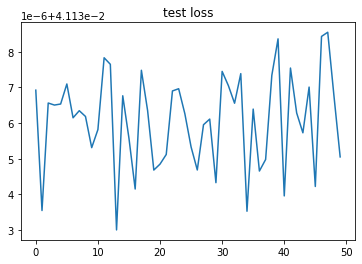

In [36]:
plt.plot(range(len(bce_list_tst)), bce_list_tst)
plt.title("BCE test")
plt.show()
plt.plot(range(len(kld_list_tst)), kld_list_tst)
plt.title("KLD test")
plt.show()
plt.plot(range(len(test_loss_list)), test_loss_list)
plt.title("test loss")
plt.show()